# Data Preprocessing of output flow of gas turbines

### Import of libraries

In [1]:
import os
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lttb

Need to specify the global variables such as where the data lies and what sampling rate the processed data should have

In [2]:
TOTAL_TIME = 12231 #total time for experiment in seconds
SAMPLING_RATE = 1 #number of samples per seconds wished (so 0.5 for a sample every 2 seconds)
sample_size = math.ceil(TOTAL_TIME*SAMPLING_RATE)
time_downsampled = range(sample_size)

OPEN_FOLDER = "../Data/Raw_Data/" # where are the raw matlab files?
SAVE_FOLDER = "../Data/Temp_Data/" # where do you want to save the .csv files

if not os.path.exists(SAVE_FOLDER):
    os.mkdir(SAVE_FOLDER)
    print('Creation of dircetory %s successful.' % SAVE_FOLDER)

In [3]:
def openFileWithMultipleHeaders(path):
    group_data = {}
    for head in mat_file.keys():
        group_data[head] = np.squeeze(mat_file[head][:])
    return group_data

In [4]:
#import all .matlab-files from data folder
raw_data = {}

mat_raw_files = (file for file in os.listdir(OPEN_FOLDER) if file[-4:] == '.mat' and "_Test_" in file)
for file in mat_raw_files:
    print(file)
    path = os.path.join(OPEN_FOLDER, file)
    mat_file = h5py.File(path, 'r')
    if len(mat_file.keys()) >1:
        group_data = openFileWithMultipleHeaders(path)
    else:
        group_data = mat_file[:]
    
    raw_data[file[:-4]] = group_data

Daten_Test_ID_4b_1B_el.mat
Daten_Test_ID_4b_1B_th.mat
Daten_Test_ID_4b_2A_el_1.mat
Daten_Test_ID_4b_2A_el_2.mat
Daten_Test_ID_4b_2A_th.mat
Drehzahldaten_Test_ID_4b.mat
Leistungdaten_Test_ID_4b.mat


## General preperations
Such as splitting the data, provide universal nomenclature and other methods useful for all data set files

We use the Largest-Triangle-Three-Bucket-Downsampling method, which [1] discovered to be best overall.

[1]: https://skemman.is/bitstream/1946/15343/3/SS_MSthesis.pdf

In [5]:
def downsampleData(time, values):
    assert len(time) == len(values)
    data = np.array([time, values]).T
    downsampled_data = lttb.downsample(data, n_out = sample_size)
    assert downsampled_data.shape[0] == sample_size
    return downsampled_data

In [8]:
def downsampleSheet(sheet, time_head):
    data_down = {}
    sheet_time = sheet[time_head]
    for head in sheet.keys():
        if len(sheet_time) > 100000000:
            sheet_time = sheet_time[::1000]
            sheet[head] = sheet[head][::1000]
        data_down[head] = downsampleData(sheet_time, sheet[head])[:,1]
        if head == time_head:
            data_down[head] = time_downsampled
    
    return data_down

In [9]:
data = {}
switcher_time = {
    'Daten_Test_ID_4b_1B_el': 't_1B_el',
    'Daten_Test_ID_4b_1B_th': 't_1B_th',
    'Daten_Test_ID_4b_2A_el_1': 't_2A_el_1',
    'Daten_Test_ID_4b_2A_el_2': 't_2A_el_2',
    'Daten_Test_ID_4b_2A_th': 't_2A_th',
    'Drehzahldaten_Test_ID_4b': 't_nsoll_stil',
    'Leistungdaten_Test_ID_4b': 't_elstil'
}

exclude = ['Drehzahldaten_Test_ID_4b', 'Leistungdaten_Test_ID_4b']
for head in [x for x in raw_data.keys() if x not in exclude]:
    print(head)
    data[head] = downsampleSheet(raw_data[head], switcher_time.get(head))

Daten_Test_ID_4b_1B_el
Daten_Test_ID_4b_1B_th
Daten_Test_ID_4b_2A_el_1
Daten_Test_ID_4b_2A_el_2
Daten_Test_ID_4b_2A_th


In [12]:
data_1B_el = data['Daten_Test_ID_4b_1B_el']
data_1B_th = data['Daten_Test_ID_4b_1B_th']
data_2A_el_1 = data['Daten_Test_ID_4b_2A_el_1']
data_2A_el_2 = data['Daten_Test_ID_4b_2A_el_2']
data_2A_th = data['Daten_Test_ID_4b_2A_th']
data_drehzahl = raw_data['Drehzahldaten_Test_ID_4b']
data_power = raw_data['Leistungdaten_Test_ID_4b']

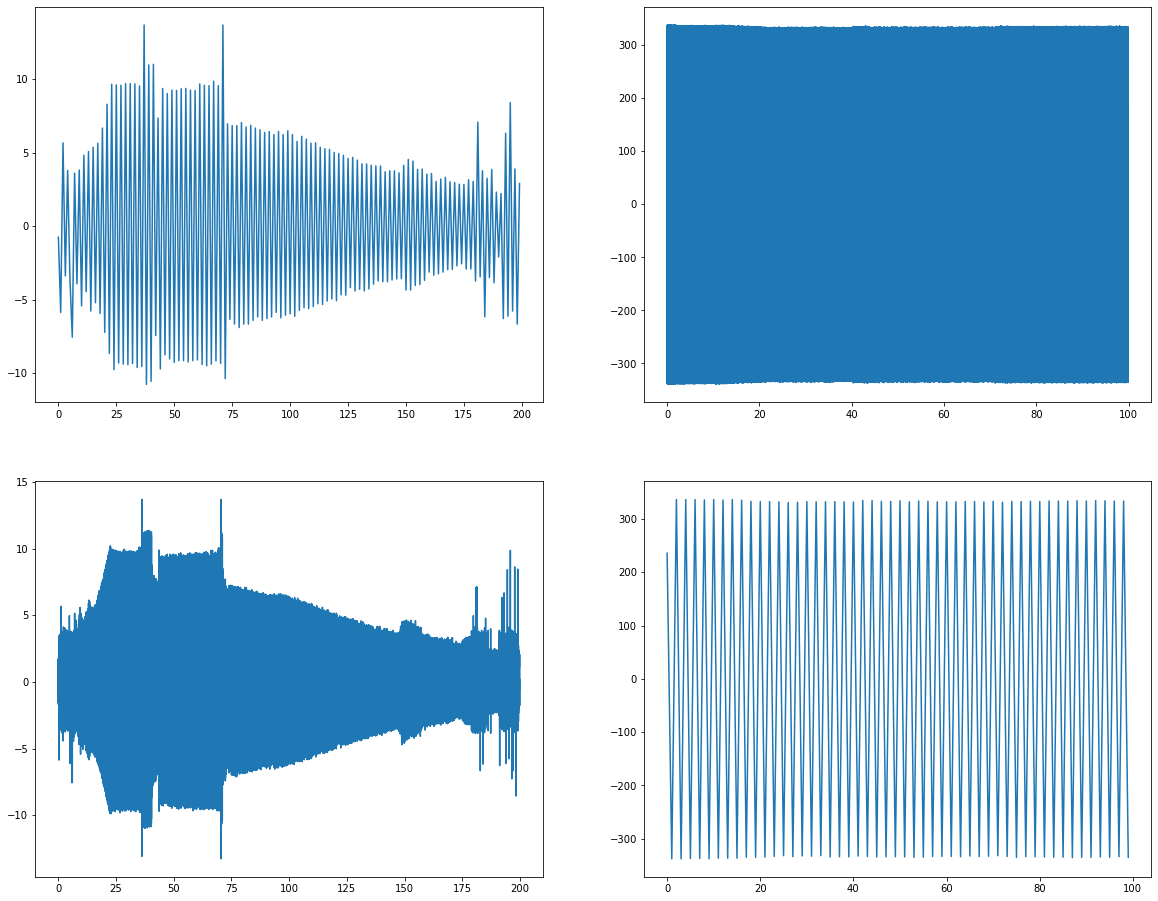

In [16]:
#those figures are for visual comparison of the downsampling method to see if it's relevant
fig,axs = plt.subplots(2, 2, figsize = (20,16))
axs = axs.ravel()
axs[0].plot(time_downsampled[:200], data_1B_el['I_N15'][:200])
axs[2].plot(raw_data['Daten_Test_ID_4b_1B_el']['t_1B_el'][:1000000], raw_data['Daten_Test_ID_4b_1B_el']['I_N15'][:1000000])
axs[1].plot(raw_data['Daten_Test_ID_4b_1B_el']['t_1B_el'][:500000], raw_data['Daten_Test_ID_4b_1B_el']['U_N'][:500000])
axs[3].plot(time_downsampled[:100], data_1B_el['U_N'][:100])
plt.show()

el_measures_1B = pd.DataFrame([{'el_time_measures': data_1B_el['t_1B_el'][::10],
                             'el_stromstaerke': data_1B_el['I_N15'][::10],
                            'el_spannung': data_1B_el['U_N'][::10]}])

el_measures_1B.to_csv(SAVE_FOLDER + "el_measures_1B.csv",
                     index = False, sep = "|", encoding = "utf-8")

## Seperate visualisation/adaptation for all data files and saving them in extra file in /Temp_Data/*

**Testdaten 1B_el (electrical output)**

The pure physical outputs as of voltage and amperage which show a periodical and symetrical stage

**Testdaten 1B_th (thermical output)**

The thermical output depending on multiple data series. Not quite sure what they mean for now, but BP_34, BT_34 and BT_6 seem like they have some correlation with the total thermical output.

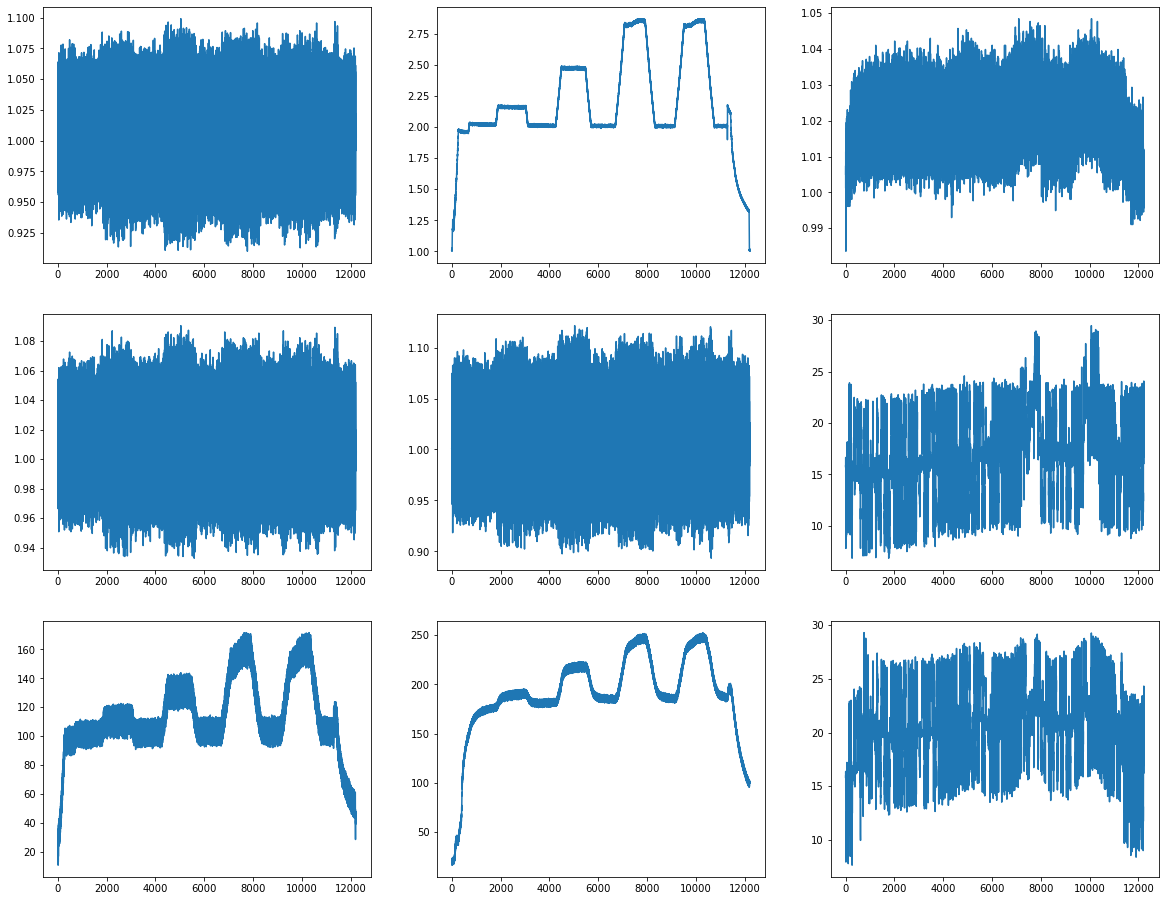

In [17]:
fig,axs = plt.subplots(3, 3, figsize = (20,16))
axs = axs.ravel()
axs[0].plot(data_1B_th['t_1B_th'], data_1B_th['BP_2'])
axs[1].plot(data_1B_th['t_1B_th'], data_1B_th['BP_34'])
axs[2].plot(data_1B_th['t_1B_th'], data_1B_th['BP_5'])
axs[3].plot(data_1B_th['t_1B_th'], data_1B_th['BP_6'])
axs[4].plot(data_1B_th['t_1B_th'], data_1B_th['BP_7'])
axs[5].plot(data_1B_th['t_1B_th'], data_1B_th['BT_2'])
axs[6].plot(data_1B_th['t_1B_th'], data_1B_th['BT_34'])
axs[7].plot(data_1B_th['t_1B_th'], data_1B_th['BT_6'])
axs[8].plot(data_1B_th['t_1B_th'], data_1B_th['BT_7'])
plt.show()

th_measures_1B = pd.DataFrame([{'th_time_measures': data_1B_th['t_1B_th'],
                             'th_BP2': data_1B_th['BP_2'],
                             'th_BP34': data_1B_th['BP_34'],
                             'th_BP5': data_1B_th['BP_5'],
                             'th_BP6': data_1B_th['BP_6'],
                             'th_BP7': data_1B_th['BP_7'],
                             'th_BT2': data_1B_th['BT_2'],
                             'th_BT34': data_1B_th['BT_34'],
                             'th_BT6': data_1B_th['BT_6'],
                             'th_BT7': data_1B_th['BT_7']}])

th_measures_1B.to_csv(SAVE_FOLDER + "th_measures_1B.csv",
                     index = False, sep = "|", encoding = "utf-8")

**Testdaten 2A_el_1 (electrical output)**

The pure physical outputs as of voltage and amperage which show a periodical and symetrical stage

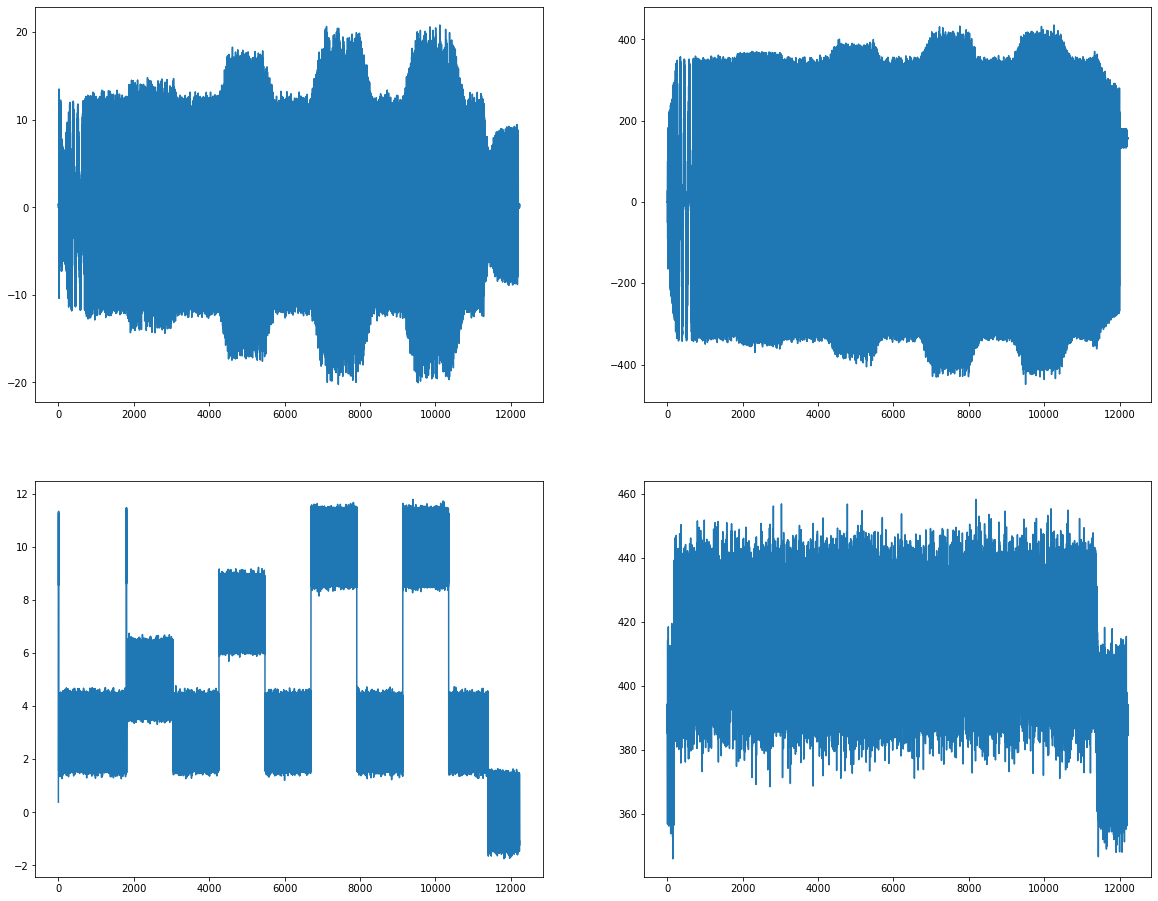

In [18]:
fig,axs = plt.subplots(2, 2, figsize = (20,16))
axs = axs.ravel()
axs[0].plot(data_2A_el_1['t_2A_el_1'], data_2A_el_1['I_G15'])
axs[1].plot(data_2A_el_1['t_2A_el_1'], data_2A_el_1['U_G'])
axs[2].plot(data_2A_el_2['t_2A_el_2'], data_2A_el_2['sw_MGT'])
axs[3].plot(data_2A_el_2['t_2A_el_2'], data_2A_el_2['U_ZK'])
plt.show()

el_measures_2A_1 = pd.DataFrame([{'el_time_measures': data_2A_el_1['t_2A_el_1'],
                             'el_stromstaerke': data_2A_el_1['I_G15'],
                            'el_spannung': data_2A_el_1['U_G']}])

el_measures_2A_1.to_csv(SAVE_FOLDER + "el_measures_2A_1.csv",
                     index = False, sep = "|", encoding = "utf-8")

el_measures_2A_2 = pd.DataFrame([{'el_time_measures': data_2A_el_2['t_2A_el_2'],
                             'el_spannung_input': data_2A_el_2['sw_MGT'],
                            'el_spannung': data_2A_el_2['U_ZK']}])

el_measures_2A_2.to_csv(SAVE_FOLDER + "el_measures_2A_2.csv",
                     index = False, sep = "|", encoding = "utf-8")

**Testdaten 2A_th (thermical output)**

The thermical output depending on multiple data series. Not quite sure what they mean for now, but V_dotKW and T_vorKW seem relevant for cold starts

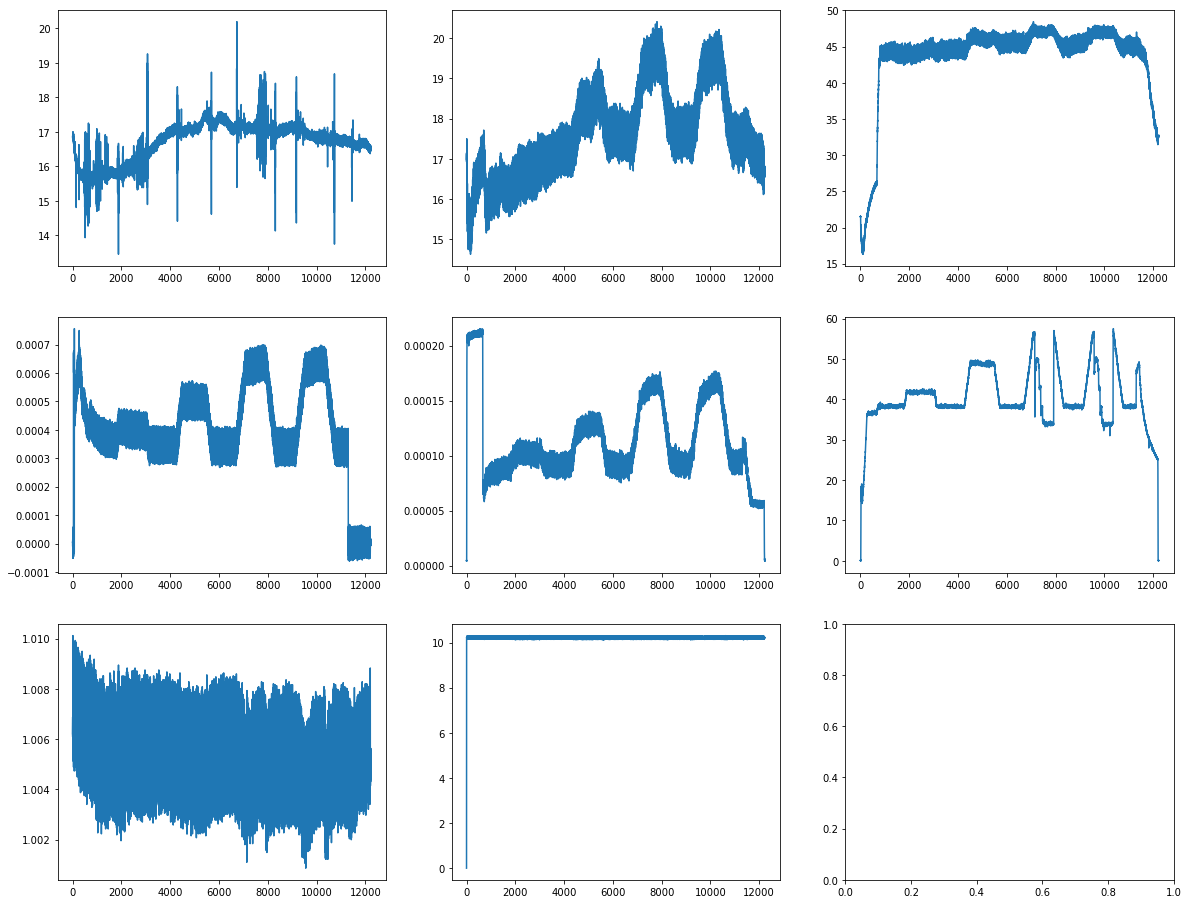

In [19]:
fig,axs = plt.subplots(3, 3, figsize = (20,16))
axs = axs.ravel()
axs[0].plot(data_2A_th['t_2A_th'], data_2A_th['T_L'])
axs[1].plot(data_2A_th['t_2A_th'], data_2A_th['T_rueckKW'])
axs[2].plot(data_2A_th['t_2A_th'], data_2A_th['T_vorKW'])
axs[3].plot(data_2A_th['t_2A_th'], data_2A_th['V_dotB'])
axs[4].plot(data_2A_th['t_2A_th'], data_2A_th['V_dotKW'])
axs[5].plot(data_2A_th['t_2A_th'], data_2A_th['m_dotL'])
axs[6].plot(data_2A_th['t_2A_th'], data_2A_th['p_L'])
axs[7].plot(data_2A_th['t_2A_th'], data_2A_th['sw_kuehler'])
plt.show()

th_measures_2A = pd.DataFrame([{'th_time_measures': data_2A_th['t_2A_th'],
                             'th_TL': data_2A_th['T_L'],
                             'th_Trueck': data_2A_th['T_rueckKW'],
                             'th_Tvor': data_2A_th['T_vorKW'],
                             'th_VdotB': data_2A_th['V_dotB'],
                             'th_VdotKW': data_2A_th['V_dotKW'],
                             'th_mdotL': data_2A_th['m_dotL'],
                             'th_pL': data_2A_th['p_L'],
                             'th_swKuehler': data_2A_th['sw_kuehler']}])

th_measures_2A.to_csv(SAVE_FOLDER + "th_measures_2A.csv",
                     index = False, sep = "|", encoding = "utf-8")

**Drehzahldaten (rotation)**

We focus on rotation data, so data from File _'Drehzahldaten_Test_ID_4b'_

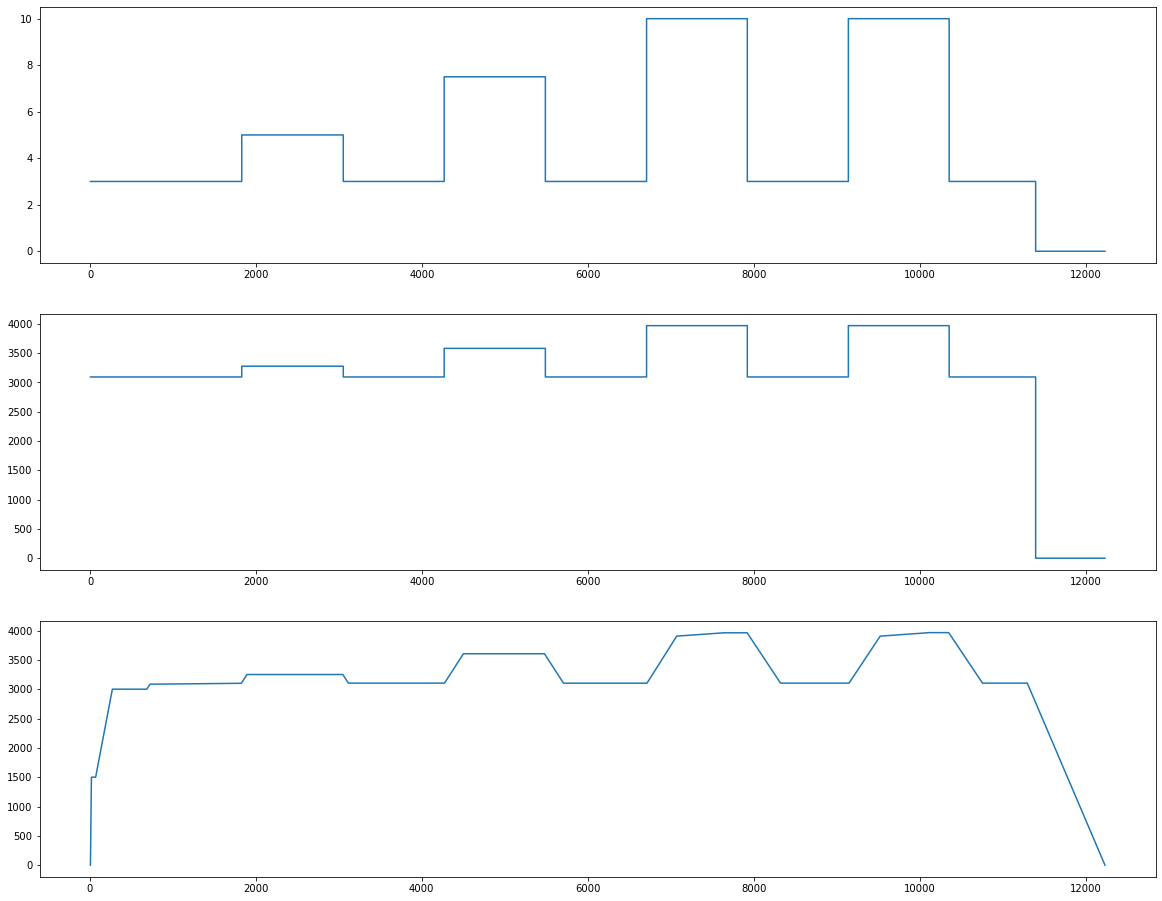

In [20]:
fig,axs = plt.subplots(3, 1, figsize = (20,16))
axs = axs.ravel()
axs[0].plot(data_drehzahl['t_nsoll_stil'], data_drehzahl['sw_nsoll_stil'])
axs[1].plot(data_drehzahl['t_nsoll_stil'], data_drehzahl['n_4b_soll'])
axs[2].plot(data_drehzahl['t_stil'], data_drehzahl['n_stil'])
plt.show()

#save the 3 different timelines in 2 data frames
#(input voltage and measured rotation vs. smoothed rotation)
input_drehzahl = pd.DataFrame([{'nsoll_time': data_drehzahl['t_nsoll_stil'],
                  'nsoll_input_voltage': data_drehzahl['sw_nsoll_stil'],
                    'nsoll_measured': data_drehzahl['n_4b_soll']}])
approx_drehzahl = pd.DataFrame([{'nsoll_time': data_drehzahl['t_stil'],
                  'nsoll_approx': data_drehzahl['n_stil']}])


input_drehzahl.to_csv(SAVE_FOLDER + "input_drehzahl.csv",
                     index = False, sep = "|", encoding = "utf-8")
approx_drehzahl.to_csv(SAVE_FOLDER + "approx_drehzahl.csv",
                     index = False, sep = "|", encoding = "utf-8")

**Leistungsdaten (power)**

We focus on power data, so data from File _'Leistungsdaten_Test_ID_4b'_

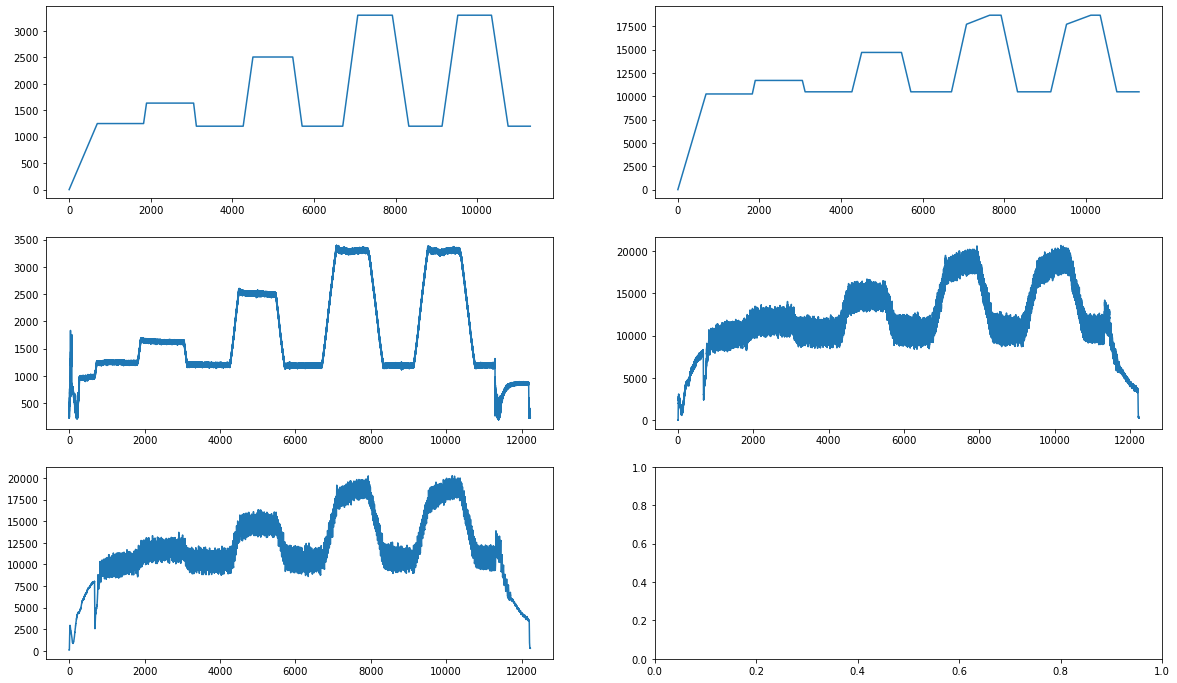

In [23]:
fig,axs = plt.subplots(3, 2, figsize = (20,12))
axs = axs.ravel()
axs[0].plot(data_power['t_elstil'], data_power['P_elstil'])
axs[1].plot(data_power['t_thstil'], data_power['P_thstil'])
axs[2].plot(data_power['t_1B_el_neu'], data_power['P_el_rms'])
axs[3].plot(data_power['t_1B_el_neu'], data_power['P_th'][::2])
axs[4].plot(data_power['t_1B_el_neu'][::25], data_power['P_th_mean'])
plt.show()


el_output_raw = pd.DataFrame([{'el_time': data_power['t_1B_el_neu'],
                  'el_power': data_power['P_el_rms'],
                    'th_power': data_power['P_th'],
                    'th_mean': data_power['P_th_mean']}])
el_output_approx = pd.DataFrame([{'el_time_approx': data_power['t_elstil'],
                  'el_power_approx': data_power['P_elstil'],
                    'th_power_approx': data_power['P_thstil']}])


el_output_raw.to_csv(SAVE_FOLDER + "el_output_raw.csv",
                     index = False, sep = "|", encoding = "utf-8")
el_output_approx.to_csv(SAVE_FOLDER + "el_output_approx.csv",
                     index = False, sep = "|", encoding = "utf-8")